# Понимание Proximal Policy Optimization (PPO): Полное руководство

## Содержание

- [Введение](#введение)
- [Что такое PPO?](#что-такое-ppo)
  - [Почему PPO? Преимущества перед TRPO и Vanilla PG](#почему-ppo)
- [Где и как используется PPO](#где-и-как-используется-ppo)
- [Математические основы PPO](#математические-основы-ppo)
  - [Повторение Policy Gradient и Surrogate Objective](#повторение-policy-gradient-и-surrogate-objective)
  - [Проблема больших обновлений политики](#проблема-больших-обновлений-политики)
  - [Clipped Surrogate Objective PPO ($L^{CLIP}$)](#clipped-surrogate-objective-ppo-lclip)
  - [Функция потерь Value Function ($L^{VF}$)](#функция-потерь-value-function-lvf)
  - [Опционально: Бонус за энтропию ($S$)](#опционально-бонус-за-энтропию-s)
  - [Комбинированный Objective PPO](#комбинированный-objective-ppo)
  - [Оценка преимуществ: GAE](#оценка-преимуществ-gae)
  - [Множественные эпохи обновления](#множественные-эпохи-обновления)
- [Пошаговое объяснение PPO](#пошаговое-объяснение-ppo)
- [Ключевые компоненты PPO](#ключевые-компоненты-ppo)
  - [Policy Network (Actor)](#policy-network-actor)
  - [Value Network (Critic)](#value-network-critic)
  - [Сбор данных (On-Policy)](#сбор-данных-on-policy)
  - [Оценка преимуществ (GAE)](#оценка-преимуществ-gae)
  - [Clipped Surrogate Objective](#clipped-surrogate-objective)
  - [Обновление Value Function](#обновление-value-function)
  - [Множественные эпохи и мини-батчи](#множественные-эпохи-и-мини-батчи)
  - [Гиперпараметры](#гиперпараметры)
- [PPO и большие языковые модели (LLMs) - RLHF](#ppo-и-большие-языковые-модели-llms---rlhf)
  - [Проблема согласования](#проблема-согласования)
  - [Обучение с подкреплением на основе человеческой обратной связи (RLHF)](#обучение-с-подкреплением-на-основе-человеческой-обратной-связи-rlhf)
  - [Как PPO вписывается в эту схему](#как-ppo-вписывается-в-эту-схему)
  - [Objective RLHF с PPO](#objective-rlhf-с-ppo)
  - [Почему PPO для LLMs?](#почему-ppo-для-llms)
  - [Проблемы](#проблемы)
- [Практический пример: Пользовательский Grid World](#практический-пример-пользовательский-grid-world)
- [Настройка окружения](#настройка-окружения)
- [Создание пользовательского окружения](#создание-пользовательского-окружения)
- [Реализация алгоритма PPO](#реализация-алгоритма-ppo)
  - [Определение Actor Network](#определение-actor-network)
  - [Определение Critic Network](#определение-critic-network)
  - [Расчет Generalized Advantage Estimation (GAE)](#расчет-generalized-advantage-estimation-gae)
  - [Шаг обновления PPO](#шаг-обновления-ppo)
- [Запуск алгоритма PPO](#запуск-алгоритма-ppo)
  - [Настройка гиперпараметров](#настройка-гиперпараметров)
  - [Инициализация](#инициализация)
  - [Цикл обучения](#цикл-обучения)
- [Визуализация процесса обучения](#визуализация-процесса-обучения)
- [Анализ обученной политики (опциональная визуализация)](#анализ-обученной-политики-опциональная-визуализация)
- [Типичные проблемы и решения в PPO](#типичные-проблемы-и-решения-в-ppo)
- [Заключение](#заключение)

## Введение

Proximal Policy Optimization (PPO) — это современный алгоритм policy gradient, который стал стандартным выбором для многих задач обучения с подкреплением, особенно в задачах непрерывного управления. Он основан на идеях Trust Region Policy Optimization (TRPO), но использует более простой механизм — *clipped surrogate objective* — для ограничения обновлений политики и обеспечения стабильного обучения, что делает его проще в реализации и настройке, при этом часто достигая сравнимой или лучшей производительности.

## Что такое PPO?

PPO — это **on-policy**, **actor-critic** алгоритм. Как и другие методы policy gradient, он непосредственно обучает политику $\pi(a|s; \theta)$. Ключевые характеристики:

1. **Структура Actor-Critic:** Использует две сети: Actor (policy network $\pi_\theta$) для выбора действий и Critic (value network $V_\phi$) для оценки состояний и помощи в оценке преимуществ.
2. **On-Policy сбор данных:** Собирает траектории опыта с использованием *текущей* политики.
3. **Clipped Surrogate Objective:** Вместо сложного ограничения KL и оптимизации второго порядка в TRPO, PPO использует более простую функцию objective первого порядка, которая штрафует большие изменения в вероятностном соотношении $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$. Этот механизм clipping эффективно удерживает новую политику близко к старой.
4. **Множественные эпохи обновления:** PPO обычно выполняет несколько эпох градиентных обновлений на одном и том же наборе собранных данных, что значительно улучшает эффективность использования данных по сравнению с методами, которые отбрасывают данные после одного обновления (как REINFORCE или стандартный A2C).

### Почему PPO? Преимущества перед TRPO и Vanilla PG

- **Простота:** Clipped objective PPO намного проще реализовать, чем FVP, CG и line search в TRPO. Он использует стандартный стохастический градиентный подъем.
- **Стабильность:** Механизм clipping обеспечивает аналогичные преимущества стабильности, как и trust region в TRPO, предотвращая разрушительные большие обновления политики, которые могут возникать в vanilla policy gradients.
- **Эффективность:** Как правило, более эффективен по выборкам, чем vanilla policy gradients, благодаря множественным обновлениям на одном батче, и часто вычислительно быстрее на одно обновление, чем TRPO.
- **Производительность:** Достигает современных результатов в широком диапазоне тестов, особенно в задачах непрерывного управления.

## Где и как используется PPO

PPO — один из самых популярных и широко используемых алгоритмов RL на сегодняшний день:

1. **Непрерывное управление:** Симуляция робототехники (MuJoCo), задачи передвижения и манипулирования.
2. **Видеоигры:** Сложные игры, требующие sophisticated policies (например, Dota 2, StarCraft).
3. **Согласование больших языковых моделей:** Используется в Reinforcement Learning from Human Feedback (RLHF) для тонкой настройки LLM, таких как ChatGPT.
4. **Общие бенчмарки RL:** Часто служит сильным baseline для разработки новых алгоритмов.

PPO подходит, когда:
- Желательно стабильное и надежное обучение.
- Ценится простота реализации по сравнению с теоретическими гарантиями TRPO.
- Пространство действий дискретное или непрерывное.
- Возможно on-policy взаимодействие.
- Требуется хорошая эффективность по выборкам (по сравнению с другими on-policy методами).

## Математические основы PPO

### Повторение Policy Gradient и Surrogate Objective
Напомним surrogate objective TRPO с использованием importance sampling:
$$ L_{\theta_{old}}(\theta) = \mathbb{E}_{t} \left[ \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)} \hat{A}_t \right] = \mathbb{E}_{t} [ r_t(\theta) \hat{A}_t ] $$
где $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ — это вероятностное соотношение, а $\hat{A}_t$ — оценка преимущества при старой политике $\pi_{\theta_{old}}$.

### Проблема больших обновлений политики
Максимизация $L_{\theta_{old}}(\theta)$ напрямую с большими шагами может быть проблематичной, потому что если $r_t(\theta)$ становится очень большим или маленьким, обновление становится нестабильным. TRPO решал это с помощью ограничения KL.

### Clipped Surrogate Objective PPO ($L^{CLIP}$)
PPO вводит более простой способ ограничения больших соотношений $r_t(\theta)$ с помощью clipping objective:
$$ L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \quad \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right] $$
Здесь:
- $\epsilon$ — это маленький гиперпараметр (например, 0.1 или 0.2), определяющий диапазон clipping.
- $\text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)$ ограничивает соотношение $r_t(\theta)$ интервалом $[1 - \epsilon, 1 + \epsilon]$.
- Функция $\min$ выбирает минимум из оригинального objective ($r_t(\theta) \hat{A}_t$) и clipped версии ($\text{clip}(...) \hat{A}_t$).

**Интуиция:**
- Если $\hat{A}_t > 0$ (действие было лучше среднего): Objective увеличивается с ростом $r_t(\theta)$ (делая действие более вероятным). Однако увеличение ограничено, когда $r_t(\theta)$ превышает $1 + \epsilon$, предотвращая слишком большие обновления, вызванные этим одним хорошим действием.
- Если $\hat{A}_t < 0$ (действие было хуже среднего): Objective уменьшается с ростом $r_t(\theta)$ (делая действие менее вероятным). Clipping term $\text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)$ становится активным, когда $r_t(\theta)$ падает ниже $1 - \epsilon$. Выбор $\min$ гарантирует, что мы используем терм, который дает *меньший* (менее отрицательный или более положительный) objective, эффективно ограничивая, насколько мы уменьшаем вероятность этого действия за один шаг.

По сути, clipping устраняет стимул для политики меняться слишком сильно ($r_t$ далеко от 1.0) за одно обновление на основе текущей оценки преимущества.

### Функция потерь Value Function ($L^{VF}$)
Как и многие actor-critic методы, PPO обучает value network $V_\phi(s)$ для оценки state values, в основном используемых для расчета преимуществ. Value network обучается путем минимизации квадратичной ошибки между его предсказаниями и некоторым целевым значением (часто эмпирическим return или GAE advantage + старое значение):
$$ L^{VF}(\phi) = \mathbb{E}_t [(V_\phi(s_t) - V_t^{targ})^2] $$
где $V_t^{targ}$ может быть discounted return $G_t$ или $\hat{A}_t^{GAE} + V_{\phi_{old}}(s_t)$.

### Опционально: Бонус за энтропию ($S$)
Для поощрения исследования и предотвращения преждевременной сходимости к субоптимальным детерминированным политикам часто добавляется бонус за энтропию. Цель — максимизировать энтропию политики $H(\pi_\theta(\cdot|s_t))$.
$$ S[\pi_\theta](s_t) = \mathbb{E}_{a \sim \pi_\theta(\cdot|s_t)} [-\log \pi_\theta(a|s_t)] $$

### Комбинированный Objective PPO
Финальная функция objective часто объединяет policy surrogate loss, value function loss и бонус за энтропию:
$$ L^{PPO}(\theta, \phi) = \mathbb{E}_t [ L^{CLIP}(\theta) - c_1 L^{VF}(\phi) + c_2 S[\pi_\theta](s_t) ] $$
где $c_1$ и $c_2$ — коэффициенты (гиперпараметры). Часто политика и value losses оптимизируются отдельно с использованием соответствующих градиентов, хотя они могут разделять нижние слои сети.

### Оценка преимуществ: GAE
PPO обычно использует Generalized Advantage Estimation (GAE), идентично его использованию в TRPO, для получения стабильных и низковариативных оценок преимуществ $\hat{A}_t$.
$$ \hat{A}^{GAE}_t = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}, \quad \text{где} \quad \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t) $$

### Множественные эпохи обновления
Ключевая особенность PPO — выполнение нескольких шагов градиентного спуска (эпох) на одном и том же наборе собранного опыта. Это улучшает эффективность использования данных. Механизм clipping предотвращает слишком сильное отклонение политики от $\pi_{\theta_{old}}$ даже при множественных обновлениях с использованием одних и тех же данных.

## Пошаговое объяснение PPO

1. **Инициализация:** Policy network $\pi(a|s; \theta)$ (Actor), Value network $V(s; \phi)$ (Critic), гиперпараметры ($\gamma, \lambda, \epsilon, c_1, c_2$, learning rates, эпохи, размер батча/шагов на итерацию).
2. **Для каждой итерации:**
    a. **Сбор траекторий:** Используя текущую политику $\pi_{\theta_{old}} = \pi(\cdot | \cdot; \theta)$, собрать батч траекторий (состояния, действия, награды, флаги завершения, следующие состояния и логарифмы вероятностей $\log \pi_{\theta_{old}}(a_t|s_t)$).
    b. **Оценка значений и преимуществ:** Вычислить $V(s_t; \phi)$ для всех состояний. Вычислить GAE преимущества $\hat{A}_t$ и returns-to-go $V_t^{targ} = \hat{A}_t + V(s_t; \phi)$ с использованием собранных данных и текущей value network.
    c. **Оптимизация (множественные эпохи):** Для K эпох:
        i. Итерироваться по собранному батчу (возможно, в мини-батчах).
        ii. Для каждого мини-батча:
            - Вычислить вероятностное соотношение $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)} = \exp(\log \pi_\theta(a_t|s_t) - \log \pi_{\theta_{old}}(a_t|s_t))$.
            - Вычислить clipped surrogate objective $L^{CLIP}$.
            - Вычислить value function loss $L^{VF}$.
            - (Опционально) Вычислить бонус за энтропию $S$.
            - Вычислить комбинированную потерю (например, $L = -L^{CLIP} + c_1 L^{VF} - c_2 S$).
            - Выполнить шаг градиентного спуска по $\theta$ и $\phi$ с использованием комбинированной потери или отдельных потерь.
3. **Повторять:** До сходимости.

## Ключевые компоненты PPO

### Policy Network (Actor)
- Параметризует стохастическую политику $\pi(a|s; \theta)$, выводит вероятности действий или параметры распределения.

### Value Network (Critic)
- Параметризует state-value функцию $V(s; \phi)$, используется для GAE.
- Обучается через MSE loss.

### Сбор данных (On-Policy)
- Собирает батчи опыта с использованием *текущей* политики $\pi_{\theta_{old}}$.
- Сохраняет состояния, действия, награды, флаги завершения и $\log \pi_{\theta_{old}}(a|s)$.

### Оценка преимуществ (GAE)
- Вычисляет оценки преимуществ с уменьшенной дисперсией $\hat{A}_t$.

### Clipped Surrogate Objective
- Основа PPO-Clip. Ограничивает влияние вероятностного соотношения $r_t(\theta)$, чтобы предотвратить слишком большие обновления.

### Обновление Value Function
- Обновляет critic network на основе наблюдаемых returns/advantages.

### Множественные эпохи и мини-батчи
- Улучшает эффективность использования данных путем повторного использования собранных данных для множественных градиентных обновлений.
- Мини-батчи могут дополнительно стабилизировать обучение внутри эпох.

### Гиперпараметры
- **Clip Range ($\epsilon$):** Определяет, насколько новая политика может отклоняться от старой (например, 0.1, 0.2).
- **GAE Lambda ($\lambda$):** Контролирует trade-off между смещением и дисперсией в оценке преимуществ (например, 0.95, 0.97).
- **Discount Factor ($\gamma$):** Стандартный RL discount (например, 0.99).
- **Learning Rate(s):** Для оптимизаторов actor и critic (часто Adam).
- **Количество эпох (K):** Сколько раз итерироваться по батчу данных (например, 4, 10).
- **Размер мини-батча:** Размер мини-батчей, используемых внутри эпох.
- **Коэффициент потерь Value Function ($c_1$):** Вес для value loss term (например, 0.5, 1.0).
- **Коэффициент энтропии ($c_2$):** Вес для бонуса за энтропию (например, 0.01, 0.001).

## PPO и большие языковые модели (LLMs) - RLHF

PPO стал краеугольным алгоритмом в согласовании больших языковых моделей (LLMs) с человеческими предпочтениями через технику под названием Reinforcement Learning from Human Feedback (RLHF). Это решает проблему, что просто предсказание следующего токена (стандартное обучение с учителем) не гарантирует, что вывод LLM будет полезным, безвредным и честным.

### Проблема согласования
LLMs, обученные на огромных объемах интернет-текста, могут генерировать беглые и осведомленные ответы, но они также могут выдавать нежелательные выводы (токсичные, предвзятые, фактически неверные, бесполезные). Мы хотим направить LLM на генерацию ответов, которые люди считают предпочтительными.

### Обучение с подкреплением на основе человеческой обратной связи (RLHF)
RLHF обычно состоит из трех этапов:

1. **Supervised Fine-Tuning (SFT):** Начните с предобученной базовой LLM. Тонко настройте ее на меньшем, высококачественном наборе данных пар prompt-response, курируемых людьми. Это адаптирует модель к желаемому стилю и домену (например, следование инструкциям, чат).

2. **Обучение Reward Model (RM):**
    * Возьмите prompts и сгенерируйте несколько ответов, используя SFT модель.
    * Люди-аннотаторы ранжируют эти ответы от лучшего к худшему на основе желаемых критериев (полезность, безвредность и т. д.).
    * Обучите отдельную модель (часто другую LLM, инициализированную из SFT модели или меньшего варианта) предсказывать эти оценки человеческих предпочтений. Вход — пара prompt-response, выход — скалярный сигнал награды.

3. **RL Fine-Tuning (PPO):**
    * Используйте SFT модель как начальную политику.
    * Используйте PPO для дальнейшей тонкой настройки этой политики.
    * **Actor:** LLM, которая настраивается.
    * **State:** Входной prompt (контекст).
    * **Пространство действий:** Словарь токенов, которые может генерировать LLM.
    * **Действие:** Генерация следующего токена в последовательности.
    * **Политика $\pi_\theta$:** Сама LLM, определяющая распределение вероятностей следующего токена при заданном контексте.
    * **Окружение:** Процесс генерации полного ответа токен за токеном, начиная с prompt.
    * **Награда:** В конце генерации ответа *Reward Model* предоставляет скалярную награду, указывающую на предсказанное качество/предпочтение для этого *целого* ответа.
    * **Обновление PPO:** PPO использует опыт (prompt, сгенерированный ответ, награда от RM) для обновления параметров LLM (actor) ($\theta$), чтобы максимизировать ожидаемую награду от RM.

### Как PPO вписывается в эту схему
На этапе RLHF:
- PPO оптимизирует политику LLM ($\pi_\theta$).
- Траектории состоят из генерации последовательностей токенов (действий) при заданном prompt (состоянии).
- Функция преимущества $\hat{A}_t$ опирается на награды от RM и потенциально value function (critic), оценивающую ожидаемую награду RM из промежуточных состояний (последовательностей токенов).
- Обновление политики направлено на увеличение вероятности последовательностей токенов, которые приводят к высоким наградам от RM.

### Objective RLHF с PPO
Важное дополнение в RLHF — это часто добавляемый штраф за KL-дивергенцию в objective PPO. Это предотвращает слишком сильное отклонение fine-tuned LLM ($\pi_\theta$) от оригинальной SFT модели ($\pi_{ref}$), гарантируя, что она сохраняет свои языковые способности и не переобучается под reward model (reward hacking).
$$ \text{Objective}_{RLHF} = \mathbb{E}_{(s,a) \sim \pi_\theta} [ R_{RM}(s, a) - \beta D_{KL}(\pi_\theta(\cdot|s) || \pi_{ref}(\cdot|s)) ] $$
Здесь $R_{RM}$ — награда от reward model, а $\beta$ контролирует силу штрафа KL. PPO используется для оптимизации этого комбинированного objective (максимизация награды RM при сохранении близости к reference policy). $L^{CLIP}$ objective неявно включает терм награды через оценку преимущества, а штраф KL добавляется явно.

### Почему PPO для LLMs?
- **Стабильность:** Тонкая настройка больших моделей требует больших вычислительных ресурсов; стабильные обновления, предотвращающие коллапс производительности, жизненно важны.
- **Эффективность по выборкам (относительно):** Хотя все еще on-policy, множественные эпохи на одном батче данных лучше используют дорогие rollout (генерация текста и получение оценок RM) по сравнению с методами с одним обновлением.
- **Простота и масштабируемость:** Проще реализовать и масштабировать в распределенных системах по сравнению с TRPO.

### Проблемы
- **Качество Reward Model:** Весь процесс зависит от наличия reward model, точно отражающей истинные человеческие предпочтения.
- **Reward Hacking:** LLM может найти способы эксплуатировать reward model для получения высоких оценок без реального улучшения качества.
- **Вычислительная стоимость:** RLHF крайне требователен к вычислительным ресурсам.
- **Настройка гиперпараметров:** Требует тщательной настройки как PPO, так и специфичных для RLHF параметров (как $\beta$).

В итоге, PPO предоставляет стабильный и относительно эффективный механизм RL оптимизации, необходимый для тонкой настройки огромных LLM на основе моделей человеческих предпочтений в конвейере RLHF.

## Практический пример: Пользовательский Grid World

Мы снова используем пользовательский Grid World для иллюстрации механики реализации PPO, сохраняя согласованность с предыдущими notebook'ами.

**Описание окружения:** (Как и раньше)
- Размер сетки: 10x10.
- Состояние: `[row/9, col/9]`
- Действия: 4 дискретных (Вверх, Вниз, Влево, Вправо).
- Старт: (0, 0), Цель: (9, 9).
- Награды: +10 (цель), -1 (стена), -0.1 (шаг).
- Завершение: Цель или максимальное число шагов.

# Настройка окружения

Импорт библиотек

In [ ]:
# Стандартные библиотеки
import random
from typing import Dict, List, Tuple, Union

# Сторонние библиотеки
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# Глобальные константы и настройки
# Определяем устройство для вычислений (CUDA, если доступно, иначе CPU)
DEVICE: torch.device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
# Константа для инициализации генераторов случайных чисел для воспроизводимости
SEED: int = 42

# Вывод используемого устройства
print(f"Используемое устройство: {DEVICE}")

# Установка зерна случайности для всех релевантных библиотек
# для обеспечения воспроизводимости экспериментов
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cpu


# Создание пользовательской среды

In [ ]:
class GridEnvironment:
    """
    Description:
    ---------------
        Реализует простую сеточную среду размером 10x10 клеток.
        Агент должен перемещаться из начальной точки (0,0) в целевую точку
        (rows-1, cols-1).

        Состояние: Координаты (строка, столбец), нормализованные в диапазон [0, 1].
        Действия: 0 (вверх), 1 (вниз), 2 (влево), 3 (вправо).
        Награды:
            +10.0 за достижение цели.
            -1.0 за столкновение со стеной (агент остается на месте).
            -0.1 за каждый выполненный шаг.
            0.0 если агент пытается сделать шаг, уже находясь в целевой точке.

    Args:
    ---------------
        rows (int): Количество строк в сетке (по умолчанию 10).
        cols (int): Количество столбцов в сетке (по умолчанию 10).

    Attributes:
    ---------------
        rows (int): Количество строк.
        cols (int): Количество столбцов.
        start_state (Tuple[int, int]): Начальные координаты агента.
        goal_state (Tuple[int, int]): Координаты цели.
        state (Tuple[int, int]): Текущие координаты агента.
        state_dim (int): Размерность вектора состояния (всегда 2).
        action_dim (int): Количество возможных действий (всегда 4).
        action_map (Dict[int, Tuple[int, int]]): Словарь, отображающий
                                                  действие на изменение координат.
        GOAL_REWARD (float): Награда за достижение цели.
        WALL_PENALTY (float): Штраф за столкновение со стеной.
        STEP_PENALTY (float): Штраф за каждый шаг.
        NO_REWARD_AT_GOAL_STEP (float): Награда при попытке шага из цели.
    """
    # Константы для наград и штрафов
    GOAL_REWARD:  float = 10.0
    WALL_PENALTY: float = -1.0
    STEP_PENALTY: float = -0.1
    # Награда, если агент пытается сделать шаг, уже находясь в целевой точке
    NO_REWARD_AT_GOAL_STEP: float = 0.0

    # Инициализация среды
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        """
        Description:
        ---------------
            Инициализирует сеточную среду с заданными размерами.

        Args:
        ---------------
            rows (int): Количество строк в сетке.
            cols (int): Количество столбцов в сетке.

        Returns:
        ---------------
            None

        Raises:
        ---------------
            ValueError: Если rows или cols меньше или равны 0.

        Examples:
        ---------------
            >>> env = GridEnvironment(rows=5, cols=5)
            >>> print(env.rows, env.cols)
            5 5
        """
        if rows <= 0 or cols <= 0:
            # Валидация входных данных для размеров сетки
            raise ValueError(
                "Количество строк и столбцов должно быть больше нуля."
            )

        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state:  Tuple[int, int] = (rows - 1, cols - 1)
        # Изначально агент находится в стартовом состоянии
        self.state: Tuple[int, int] = self.start_state
        # Размерность состояния - это всегда две координаты (строка, столбец)
        self.state_dim: int = 2
        # Количество действий: вверх, вниз, влево, вправо
        self.action_dim: int = 4
        # Карта действий: 0-вверх, 1-вниз, 2-влево, 3-вправо
        # Каждое действие соответствует изменению (delta_row, delta_col)
        self.action_map: Dict[int, Tuple[int, int]] = {
            0: (-1, 0),  # Вверх
            1: (1, 0),   # Вниз
            2: (0, -1),  # Влево
            3: (0, 1)    # Вправо
        }

    # Сброс среды в начальное состояние
    def reset(self) -> torch.Tensor:
        """
        Description:
        ---------------
            Сбрасывает состояние среды к начальному (агент возвращается
            на стартовую позицию).

        Args:
        ---------------
            None

        Returns:
        ---------------
            torch.Tensor: Нормализованный тензор начального состояния.

        Examples:
        ---------------
            >>> env = GridEnvironment()
            >>> initial_state_tensor = env.reset()
            >>> print(initial_state_tensor)
            tensor([0., 0.])
        """
        # Возвращаем агента в начальную позицию
        self.state = self.start_state
        # Возвращаем нормализованное тензорное представление начального состояния
        return self._get_state_tensor(self.state)

    # Получение тензорного представления состояния
    def _get_state_tensor(
        self,
        state_tuple: Tuple[int, int]
    ) -> torch.Tensor:
        """
        Description:
        ---------------
            Преобразует кортеж состояния (строка, столбец) в нормализованный
            тензор PyTorch. Нормализация производится делением на (размер-1)
            для каждой координаты, чтобы значения были в диапазоне [0, 1].

        Args:
        ---------------
            state_tuple (Tuple[int, int]): Кортеж с координатами (строка, столбец).

        Returns:
        ---------------
            torch.Tensor: Нормализованный тензор состояния.

        Raises:
        ---------------
            TypeError: Если state_tuple не является кортежем из двух целых чисел.
                       (Неявная проверка через использование)

        Examples:
        ---------------
            >>> env = GridEnvironment()
            >>> state_tensor = env._get_state_tensor((4, 5))
            >>> # Для сетки 10x10, (4,5) -> (4/9, 5/9)
            >>> # print(state_tensor) # tensor([0.4444, 0.5556]) (примерно)
        """
        # Нормализация координаты строки. Если всего одна строка, нормализация не нужна (0.0).
        # Это предотвращает деление на ноль, если self.rows = 1.
        norm_row: float = (
            state_tuple[0] / (self.rows - 1) if self.rows > 1 else 0.0
        )
        # Нормализация координаты столбца. Аналогично для столбцов.
        norm_col: float = (
            state_tuple[1] / (self.cols - 1) if self.cols > 1 else 0.0
        )
        normalized_state: List[float] = [norm_row, norm_col]
        # Преобразование в тензор PyTorch с указанием типа и устройства
        return torch.tensor(
            normalized_state, dtype=torch.float32, device=DEVICE
        )

    # Выполнение шага в среде
    def step(
        self,
        action: int
    ) -> Tuple[torch.Tensor, float, bool]:
        """
        Description:
        ---------------
            Выполняет указанное действие в среде, изменяет состояние агента,
            рассчитывает награду и определяет, завершен ли эпизод.

        Args:
        ---------------
            action (int): Целочисленное представление действия (0-3).

        Returns:
        ---------------
            Tuple[torch.Tensor, float, bool]: Кортеж, содержащий:
                - next_state_tensor (torch.Tensor): Новое состояние (нормализованный тензор).
                - reward (float): Полученная награда.
                - done (bool): Флаг, указывающий на завершение эпизода
                               (True, если цель достигнута).

        Raises:
        ---------------
            KeyError: Если переданное значение `action` отсутствует в `self.action_map`.
                      (Неявная проверка при доступе к `self.action_map[action]`)

        Examples:
        ---------------
            >>> env = GridEnvironment()
            >>> env.reset()
            tensor([0., 0.])
            >>> next_state, reward, done = env.step(1) # Двигаемся вниз
            >>> # print(next_state, reward, done)
            >>> # tensor([0.1111, 0.0000]), -0.1, False (примерно)
        """
        # Если агент уже находится в целевом состоянии,
        # дальнейшие шаги не меняют состояние и приносят нулевую награду.
        if self.state == self.goal_state:
            return (
                self._get_state_tensor(self.state),
                self.NO_REWARD_AT_GOAL_STEP,
                True  # Эпизод считается завершенным
            )

        # Получаем изменение координат для выбранного действия
        delta_row, delta_col = self.action_map[action]
        current_row, current_col = self.state

        # Рассчитываем предполагаемые новые координаты
        next_row: int = current_row + delta_row
        next_col: int = current_col + delta_col

        # Инициализируем награду стандартным штрафом за шаг
        reward: float = self.STEP_PENALTY

        # Проверяем, не выходит ли агент за пределы сетки (столкновение со стеной)
        if not (0 <= next_row < self.rows and
                0 <= next_col < self.cols):
            # Если выходит, агент остается на месте (координаты не меняются)
            next_row, next_col = current_row, current_col
            # Применяется штраф за столкновение со стеной
            reward = self.WALL_PENALTY
        # Обновляем текущее состояние агента
        self.state = (next_row, next_col)

        # Получаем тензорное представление нового состояния
        next_state_tensor: torch.Tensor = self._get_state_tensor(self.state)
        # Проверяем, достигнута ли цель
        done: bool = (self.state == self.goal_state)

        if done:
            # Если цель достигнута, агент получает большую положительную награду
            reward = self.GOAL_REWARD

        return next_state_tensor, reward, done

    # Получение размера пространства действий
    def get_action_space_size(self) -> int:
        """
        Description:
        ---------------
            Возвращает количество возможных действий в среде.

        Args:
        ---------------
            None

        Returns:
        ---------------
            int: Размер пространства действий (количество уникальных действий).

        Examples:
        ---------------
            >>> env = GridEnvironment()
            >>> print(env.get_action_space_size())
            4
        """
        return self.action_dim

    # Получение размерности пространства состояний
    def get_state_dimension(self) -> int:
        """
        Description:
        ---------------
            Возвращает размерность вектора состояния.

        Args:
        ---------------
            None

        Returns:
        ---------------
            int: Размерность пространства состояний.

        Examples:
        ---------------
            >>> env = GridEnvironment()
            >>> print(env.get_state_dimension())
            2
        """
        return self.state_dim

Создаем экземпляр и протестируем среду

In [ ]:
# Создание экземпляра среды GridEnvironment с сеткой 10x10
# Используем переменные с суффиксом '_custom', чтобы подчеркнуть,
# что это относится к нашему пользовательскому окружению.
custom_env: GridEnvironment = GridEnvironment(rows=10, cols=10)

# Получение размера пространства действий из среды
n_actions_custom: int = custom_env.get_action_space_size()
# Получение размерности пространства состояний из среды
n_observations_custom: int = custom_env.get_state_dimension()

print(f"Custom Grid Environment:")
print(f"Size: {custom_env.rows}x{custom_env.cols}")
print(f"State Dim: {n_observations_custom}")
print(f"Action Dim: {n_actions_custom}")
start_state_tensor = custom_env.reset()
print(f"Example state tensor for (0,0): {start_state_tensor}")

Custom Grid Environment:
Size: 10x10
State Dim: 2
Action Dim: 4
Example state tensor for (0,0): tensor([0., 0.])


# Реализация алгоритма PPO

Определяем Actor (Policy Network) и Critic (Value Network), расчет GAE и функцию обновления PPO.

### Определение Actor Network

Аналогично Policy Network, используемой в TRPO/REINFORCE.

In [ ]:
# Класс нейросетевого актора для PPO
class PolicyNetwork(nn.Module):
    """
    Description:
    ---------------
        Нейросетевая модель актора (Policy Network), реализованная 
        в виде многослойного перцептрона (MLP) с двумя скрытыми слоями 
        и выходом в виде логитов для категориального распределения.

    Args:
    ---------------
        n_observations: Размерность входного вектора наблюдений
        n_actions: Количество возможных дискретных действий

    Raises:
    ---------------
        ValueError: Если вход имеет неподходящую размерность

    Examples:
    ---------------
        >>> model = PolicyNetwork(n_observations=4, n_actions=2)
        >>> obs = torch.rand(4)
        >>> dist = model(obs)
        >>> action = dist.sample()
    """

    def __init__(self, n_observations: int, n_actions: int):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: Union[torch.Tensor, list, tuple]) -> Categorical:
        """
        Description:
        ---------------
            Прямой проход по сети, возвращающий категориальное 
            распределение действий на основе входного наблюдения.

        Args:
        ---------------
            x: Вектор наблюдений (в виде torch.Tensor, list или tuple)

        Returns:
        ---------------
            Категориальное распределение действий (torch.distributions.Categorical)

        Raises:
        ---------------
            ValueError: В случае, если вход не может быть преобразован в Tensor

        Examples:
        ---------------
            >>> obs = torch.rand(4)
            >>> model = PolicyNetwork(4, 2)
            >>> dist = model(obs)
            >>> dist.sample()
        """
        # Преобразование входа к torch.Tensor типа float32
        if not isinstance(x, torch.Tensor):
            try:
                x = torch.tensor(x, dtype=torch.float32, device=DEVICE)
            except Exception as e:
                raise ValueError(f"Не удалось преобразовать вход в Tensor: {e}")
        elif x.dtype != torch.float32:
            x = x.to(dtype=torch.float32)

        # Если вход одномерный, добавить batch-ось
        if x.dim() == 1:
            x = x.unsqueeze(0)

        # Последовательное прохождение слоев с ReLU активацией
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        action_logits = self.layer3(x)

        # Возврат категориального распределения на основе логитов
        return Categorical(logits=action_logits)

### Определение Critic Network

In [ ]:
# Класс нейросетевого критика (Value Network) для PPO
class ValueNetwork(nn.Module):
    """
    Description:
    ---------------
        Нейросетевая модель критика (Value Network), основанная 
        на MLP архитектуре. Принимает на вход наблюдение 
        и предсказывает скалярную оценку ценности состояния.

    Args:
    ---------------
        n_observations: Размерность входного вектора наблюдений

    Raises:
    ---------------
        ValueError: Если вход не может быть преобразован в Tensor

    Examples:
    ---------------
        >>> model = ValueNetwork(n_observations=4)
        >>> obs = torch.rand(4)
        >>> value = model(obs)
        >>> value.shape
        torch.Size([1, 1])
    """

    def __init__(self, n_observations: int):
        super(ValueNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, x: Union[torch.Tensor, list, tuple]) -> torch.Tensor:
        """
        Description:
        ---------------
            Выполняет прямой проход по сети и возвращает 
            оценку ценности состояния (state value).

        Args:
        ---------------
            x: Входной вектор наблюдений (может быть Tensor, list или tuple)

        Returns:
        ---------------
            Тензор с оценкой ценности состояния (shape: [batch_size, 1])

        Raises:
        ---------------
            ValueError: В случае невозможности приведения входа к тензору

        Examples:
        ---------------
            >>> obs = [0.1, 0.2, 0.3, 0.4]
            >>> model = ValueNetwork(4)
            >>> value = model(obs)
            >>> value.item()
        """
        # Приведение входа к torch.Tensor с типом float32
        if not isinstance(x, torch.Tensor):
            try:
                x = torch.tensor(x, dtype=torch.float32, device=DEVICE)
            except Exception as e:
                raise ValueError(f"Не удалось преобразовать вход в Tensor: {e}")
        elif x.dtype != torch.float32:
            x = x.to(dtype=torch.float32)

        # Добавление batch-оси при необходимости
        if x.dim() == 1:
            x = x.unsqueeze(0)

        # Последовательная активация слоев с функцией ReLU
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        state_value = self.layer3(x)

        # Возврат скалярной оценки состояния
        return state_value

### Расчет Generalized Advantage Estimation (GAE)

In [ ]:
# Вычисление генерализованной оценки преимущества (GAE)
def compute_gae(
    rewards: torch.Tensor,
    values: torch.Tensor,
    next_values: torch.Tensor,
    dones: torch.Tensor,
    gamma: float,
    lambda_gae: float,
    standardize: bool = True
) -> torch.Tensor:
    """
    Description:
    ---------------
        Вычисляет генерализованную оценку преимущества (GAE)
        на основе последовательности наград, оценок ценности и флага завершения эпизода.

    Args:
    ---------------
        rewards: Тензор с наградами на каждом шаге (shape: [T])
        values: Тензор с оценками ценности состояния на каждом шаге (shape: [T])
        next_values: Тензор с оценками ценности следующего состояния (shape: [T])
        dones: Тензор, указывающий на завершение эпизода (1.0 если конец, 0.0 иначе)
        gamma: Коэффициент дисконтирования (обычно 0.99)
        lambda_gae: Параметр сглаживания GAE (обычно 0.95)
        standardize: Флаг стандартизации преимущества (по умолчанию True)

    Returns:
    ---------------
        Тензор с оценкой преимущества для каждого шага (shape: [T])

    Raises:
    ---------------
        ValueError: Если размеры входных тензоров не совпадают

    Examples:
    ---------------
        >>> adv = compute_gae(
        ...     rewards=torch.tensor([1., 0., 1.]),
        ...     values=torch.tensor([0.5, 0.4, 0.3]),
        ...     next_values=torch.tensor([0.4, 0.3, 0.0]),
        ...     dones=torch.tensor([0.0, 0.0, 1.0]),
        ...     gamma=0.99,
        ...     lambda_gae=0.95
        ... )
        >>> adv.shape
        torch.Size([3])
    """
    # Проверка на корректность входных данных
    if not (rewards.shape == values.shape == next_values.shape == dones.shape):
        raise ValueError("Все входные тензоры должны иметь одинаковую форму")

    # Инициализация тензора преимуществ нулями
    advantages = torch.zeros_like(rewards)

    # Последнее вычисленное преимущество (bootstrap)
    last_advantage = 0.0

    # Расчёт преимуществ в обратном порядке (Time-Major)
    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]  # 0.0 если эпизод завершён, иначе 1.0
        delta = rewards[t] + gamma * next_values[t] * mask - values[t]
        advantages[t] = delta + gamma * lambda_gae * last_advantage * mask
        last_advantage = advantages[t]

    # Стандартизация преимуществ (zero mean, unit std)
    if standardize:
        mean_adv = advantages.mean()
        std_adv = advantages.std(unbiased=False) + 1e-8  # защищаем от деления на 0
        advantages = (advantages - mean_adv) / std_adv

    return advantages

### Шаг обновления PPO

In [ ]:
def update_ppo(
    actor: PolicyNetwork,
    critic: ValueNetwork,
    actor_optimizer: optim.Optimizer,
    critic_optimizer: optim.Optimizer,
    states: torch.Tensor,
    actions: torch.Tensor,
    log_probs_old: torch.Tensor,
    advantages: torch.Tensor,
    returns_to_go: torch.Tensor,
    ppo_epochs: int,
    ppo_clip_epsilon: float,
    value_loss_coeff: float,
    entropy_coeff: float
) -> Tuple[float, float, float]:
    """
    Description:
    ---------------
        Выполняет оптимизацию актор-критик модели с помощью алгоритма 
        Proximal Policy Optimization (PPO) на одном батче данных.

    Args:
    ---------------
        actor: Нейросетевая модель политики (актор)
        critic: Нейросетевая модель оценки ценности состояния (критик)
        actor_optimizer: Оптимизатор параметров актора
        critic_optimizer: Оптимизатор параметров критика
        states: Батч наблюдений
        actions: Батч совершённых действий
        log_probs_old: Логарифмы вероятностей действий от старой политики
        advantages: Оценка преимущества на каждом шаге
        returns_to_go: Возвращаемое значение для критика
        ppo_epochs: Количество эпох оптимизации на одном батче
        ppo_clip_epsilon: Параметр сжатия (clipping) политики
        value_loss_coeff: Вес функции потерь критика
        entropy_coeff: Вес бонуса энтропии (поощрение исследования)

    Returns:
    ---------------
        Кортеж из среднего значения потерь:
        (средняя политика, средняя ценность, средняя энтропия)

    Examples:
    ---------------
        >>> loss_pi, loss_v, entropy = update_ppo(
        ...     actor, critic, actor_opt, critic_opt,
        ...     states, actions, old_log_probs,
        ...     adv, returns, 10, 0.2, 0.5, 0.01
        ... )
    """
    # Инициализация накопителей потерь
    total_policy_loss = 0.0
    total_value_loss = 0.0
    total_entropy = 0.0

    # Отключаем градиенты для стабильных входных данных
    advantages = advantages.detach()
    log_probs_old = log_probs_old.detach()
    returns_to_go = returns_to_go.detach()

    for _ in range(ppo_epochs):
        # === Обновление политики (актор) ===
        policy_dist: Categorical = actor(states)
        log_probs_new = policy_dist.log_prob(actions)
        entropy = policy_dist.entropy().mean()

        # Вычисление отношения вероятностей r_t(θ)
        ratio = torch.exp(log_probs_new - log_probs_old)

        # PPO surrogate loss (две версии: unclipped и clipped)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - ppo_clip_epsilon, 1.0 + ppo_clip_epsilon) * advantages

        # Итоговая потеря политики с бонусом за энтропию
        policy_loss = -torch.min(surr1, surr2).mean() - entropy_coeff * entropy

        # Обратное распространение ошибки и шаг оптимизатора
        actor_optimizer.zero_grad()
        policy_loss.backward()
        actor_optimizer.step()

        # === Обновление ценности (критик) ===
        values_pred = critic(states).squeeze()
        value_loss = F.mse_loss(values_pred, returns_to_go)

        critic_optimizer.zero_grad()
        (value_loss_coeff * value_loss).backward()
        critic_optimizer.step()

        # Накопление статистики для логирования
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
        total_entropy += entropy.item()

    # Вычисление средних значений потерь
    avg_policy_loss = total_policy_loss / ppo_epochs
    avg_value_loss = total_value_loss / ppo_epochs
    avg_entropy = total_entropy / ppo_epochs

    return avg_policy_loss, avg_value_loss, avg_entropy

# Запуск алгоритма PPO

Настройка гиперпараметров, инициализация сетей и оптимизаторов, выполнение цикла обучения PPO.

### Настройка гиперпараметров

Определяем ключевые гиперпараметры PPO:

In [ ]:
# === PPO: Общие параметры оптимизации ===
GAMMA_PPO: float = 0.99                # Коэффициент дисконтирования (gamma)
GAE_LAMBDA_PPO: float = 0.95           # Параметр лямбда для GAE
PPO_CLIP_EPSILON: float = 0.2          # Эпсилон для обрезки ratio в PPO

# === Скорости обучения ===
ACTOR_LR: float = 3e-4                 # Скорость обучения актора
CRITIC_LR_PPO: float = 1e-3            # Скорость обучения критика

# === Эпохи и веса потерь ===
PPO_EPOCHS: int = 10                   # Кол-во эпох PPO на одну итерацию
VALUE_LOSS_COEFF: float = 0.5          # Вес ошибки критика (MSE)
ENTROPY_COEFF: float = 0.01            # Вес энтропийного бонуса (exploration)

# === Настройки преимущества ===
STANDARDIZE_ADV_PPO: bool = True       # Стандартизировать ли преимущества

# === Цикл обучения ===
NUM_ITERATIONS_PPO: int = 150          # Число итераций обновления политики
STEPS_PER_ITERATION_PPO: int = 1000    # Кол-во шагов, собираемых за итерацию
MAX_STEPS_PER_EPISODE_PPO: int = 200   # Максимум шагов в одном эпизоде

### Инициализация

Инициализация модели актора, критика и оптимизатора.

In [ ]:
# === Создание среды ===
custom_env: GridEnvironment = GridEnvironment(rows=10, cols=10)

# Получение размерностей пространства действий и состояний
n_actions_custom: int = custom_env.get_action_space_size()
n_observations_custom: int = custom_env.get_state_dimension()

# === Инициализация моделей PPO ===
# Актор предсказывает распределение действий, критик — ценность состояния
actor_ppo: PolicyNetwork = PolicyNetwork(
    n_observations=n_observations_custom,
    n_actions=n_actions_custom
).to(DEVICE)

critic_ppo: ValueNetwork = ValueNetwork(
    n_observations=n_observations_custom
).to(DEVICE)

# === Инициализация оптимизаторов ===
# Используется Adam с различными скоростями обучения
actor_optimizer_ppo: optim.Adam = optim.Adam(
    actor_ppo.parameters(), lr=ACTOR_LR
)

critic_optimizer_ppo: optim.Adam = optim.Adam(
    critic_ppo.parameters(), lr=CRITIC_LR_PPO
)

# === Структуры для логгирования и визуализации метрик ===
# Каждая итерация будет добавлять значения в эти списки
ppo_iteration_rewards: list = []           # Награды за итерацию
ppo_iteration_avg_ep_lens: list = []       # Средняя длина эпизода
ppo_iteration_policy_losses: list = []     # Потери политики (актор)
ppo_iteration_value_losses: list = []      # Потери ценности (критик)
ppo_iteration_entropies: list = []         # Энтропия политики (для разнообразия действий)

### Цикл обучения PPO

Последовательность шагов:
1. Сбор данных взаимодействия со средой
2. Вычисление оценок преимуществ (advantages) и возвратов (returns)
3. Многократное обновление:
   - Политической сети (Actor)
   - Ценностной сети (Critic)
4. Повторение процесса для заданного числа эпох

In [ ]:
print("Starting PPO Training on Custom Grid World...")

# === Основной тренировочный цикл ===
for iteration in range(NUM_ITERATIONS_PPO):

    # --- 1. Сбор траекторий (Rollout) ---
    batch_states_list = []
    batch_actions_list = []
    batch_log_probs_old_list = []
    batch_rewards_list = []
    batch_values_list = []
    batch_dones_list = []

    episode_rewards_in_iter = []
    episode_lengths_in_iter = []
    steps_collected = 0

    while steps_collected < STEPS_PER_ITERATION_PPO:
        state = custom_env.reset()
        episode_reward = 0.0
        episode_steps = 0
        done = False

        for _ in range(MAX_STEPS_PER_EPISODE_PPO):
            # Получение действия от текущей политики и оценка ценности
            with torch.no_grad():
                policy_dist = actor_ppo(state)
                value = critic_ppo(state).squeeze()
                action_tensor = policy_dist.sample()
                action = action_tensor.item()
                log_prob = policy_dist.log_prob(action_tensor)

            # Взаимодействие со средой
            next_state, reward, done = custom_env.step(action)

            # Сохраняем переход
            batch_states_list.append(state)
            batch_actions_list.append(action)
            batch_log_probs_old_list.append(log_prob)
            batch_values_list.append(value)
            batch_rewards_list.append(reward)
            batch_dones_list.append(float(done))

            state = next_state
            episode_reward += reward
            steps_collected += 1
            episode_steps += 1

            # Прерывание эпизода при завершении или достижении лимита
            if done or steps_collected >= STEPS_PER_ITERATION_PPO:
                episode_rewards_in_iter.append(episode_reward)
                episode_lengths_in_iter.append(episode_steps)
                break

        if steps_collected >= STEPS_PER_ITERATION_PPO:
            break

    # --- Завершение сбора траекторий ---

    # --- 2. Расчет next_values для GAE ---
    next_values = []
    with torch.no_grad():
        for i in range(len(batch_states_list)):
            if batch_dones_list[i] > 0.5:
                next_values.append(torch.tensor(0.0, device=DEVICE))
            elif i == len(batch_states_list) - 1:
                next_state = custom_env.step(batch_actions_list[i])[0]
                next_values.append(critic_ppo(next_state).squeeze())
            else:
                next_values.append(batch_values_list[i + 1])

    # --- 3. Конвертация списков в тензоры ---
    states_tensor = torch.stack(batch_states_list).to(DEVICE)
    actions_tensor = torch.tensor(batch_actions_list, dtype=torch.long, device=DEVICE)
    log_probs_old_tensor = torch.stack(batch_log_probs_old_list).to(DEVICE).squeeze()
    rewards_tensor = torch.tensor(batch_rewards_list, dtype=torch.float32, device=DEVICE)
    values_tensor = torch.stack(batch_values_list).to(DEVICE)
    next_values_tensor = torch.stack(next_values).to(DEVICE)
    dones_tensor = torch.tensor(batch_dones_list, dtype=torch.float32, device=DEVICE)

    # --- 4. Оценка преимуществ и returns-to-go ---
    advantages_tensor = compute_gae(
        rewards_tensor, values_tensor, next_values_tensor, dones_tensor,
        gamma=GAMMA_PPO, lambda_gae=GAE_LAMBDA_PPO, standardize=STANDARDIZE_ADV_PPO
    )
    returns_to_go_tensor = advantages_tensor + values_tensor

    # --- 5. Обновление параметров PPO ---
    avg_policy_loss, avg_value_loss, avg_entropy = update_ppo(
        actor=actor_ppo,
        critic=critic_ppo,
        actor_optimizer=actor_optimizer_ppo,
        critic_optimizer=critic_optimizer_ppo,
        states=states_tensor,
        actions=actions_tensor,
        log_probs_old=log_probs_old_tensor,
        advantages=advantages_tensor,
        returns_to_go=returns_to_go_tensor,
        ppo_epochs=PPO_EPOCHS,
        ppo_clip_epsilon=PPO_CLIP_EPSILON,
        value_loss_coeff=VALUE_LOSS_COEFF,
        entropy_coeff=ENTROPY_COEFF
    )

    # --- 6. Логгирование статистики итерации ---
    avg_reward_iter = np.mean(episode_rewards_in_iter) if episode_rewards_in_iter else float("nan")
    avg_len_iter = np.mean(episode_lengths_in_iter) if episode_lengths_in_iter else float("nan")

    ppo_iteration_rewards.append(avg_reward_iter)
    ppo_iteration_avg_ep_lens.append(avg_len_iter)
    ppo_iteration_policy_losses.append(avg_policy_loss)
    ppo_iteration_value_losses.append(avg_value_loss)
    ppo_iteration_entropies.append(avg_entropy)

    # Вывод прогресса каждые 10 итераций
    if (iteration + 1) % 10 == 0:
        print(
            f"Iter {iteration + 1}/{NUM_ITERATIONS_PPO} | "
            f"Avg Reward: {avg_reward_iter:.2f} | "
            f"Avg Len: {avg_len_iter:.1f} | "
            f"P_Loss: {avg_policy_loss:.4f} | "
            f"V_Loss: {avg_value_loss:.4f} | "
            f"Entropy: {avg_entropy:.4f}"
        )

print("Custom Grid World Training Finished (PPO).")

Starting PPO Training on Custom Grid World...
Iter 10/150 | Avg Reward: 6.36 | Avg Len: 21.3 | P_Loss: -0.0145 | V_Loss: 0.9804 | Entropy: 0.8628
Iter 20/150 | Avg Reward: 7.09 | Avg Len: 18.9 | P_Loss: -0.0118 | V_Loss: 1.0018 | Entropy: 0.6925
Iter 30/150 | Avg Reward: 7.61 | Avg Len: 18.5 | P_Loss: -0.0146 | V_Loss: 0.9844 | Entropy: 0.6553
Iter 40/150 | Avg Reward: 7.82 | Avg Len: 18.2 | P_Loss: -0.0076 | V_Loss: 0.9962 | Entropy: 0.6224
Iter 50/150 | Avg Reward: 7.89 | Avg Len: 18.2 | P_Loss: -0.0079 | V_Loss: 0.9865 | Entropy: 0.6108
Iter 60/150 | Avg Reward: 7.92 | Avg Len: 18.2 | P_Loss: -0.0082 | V_Loss: 0.9977 | Entropy: 0.5717
Iter 70/150 | Avg Reward: 7.82 | Avg Len: 18.2 | P_Loss: -0.0062 | V_Loss: 1.0129 | Entropy: 0.5540
Iter 80/150 | Avg Reward: 7.92 | Avg Len: 18.2 | P_Loss: -0.0085 | V_Loss: 1.0051 | Entropy: 0.5434
Iter 90/150 | Avg Reward: 8.01 | Avg Len: 17.9 | P_Loss: -0.0064 | V_Loss: 0.9879 | Entropy: 0.5104
Iter 100/150 | Avg Reward: 8.07 | Avg Len: 17.9 | P_Lo

# Визуализация процесса обучения

Отображение результатов работы PPO-агента

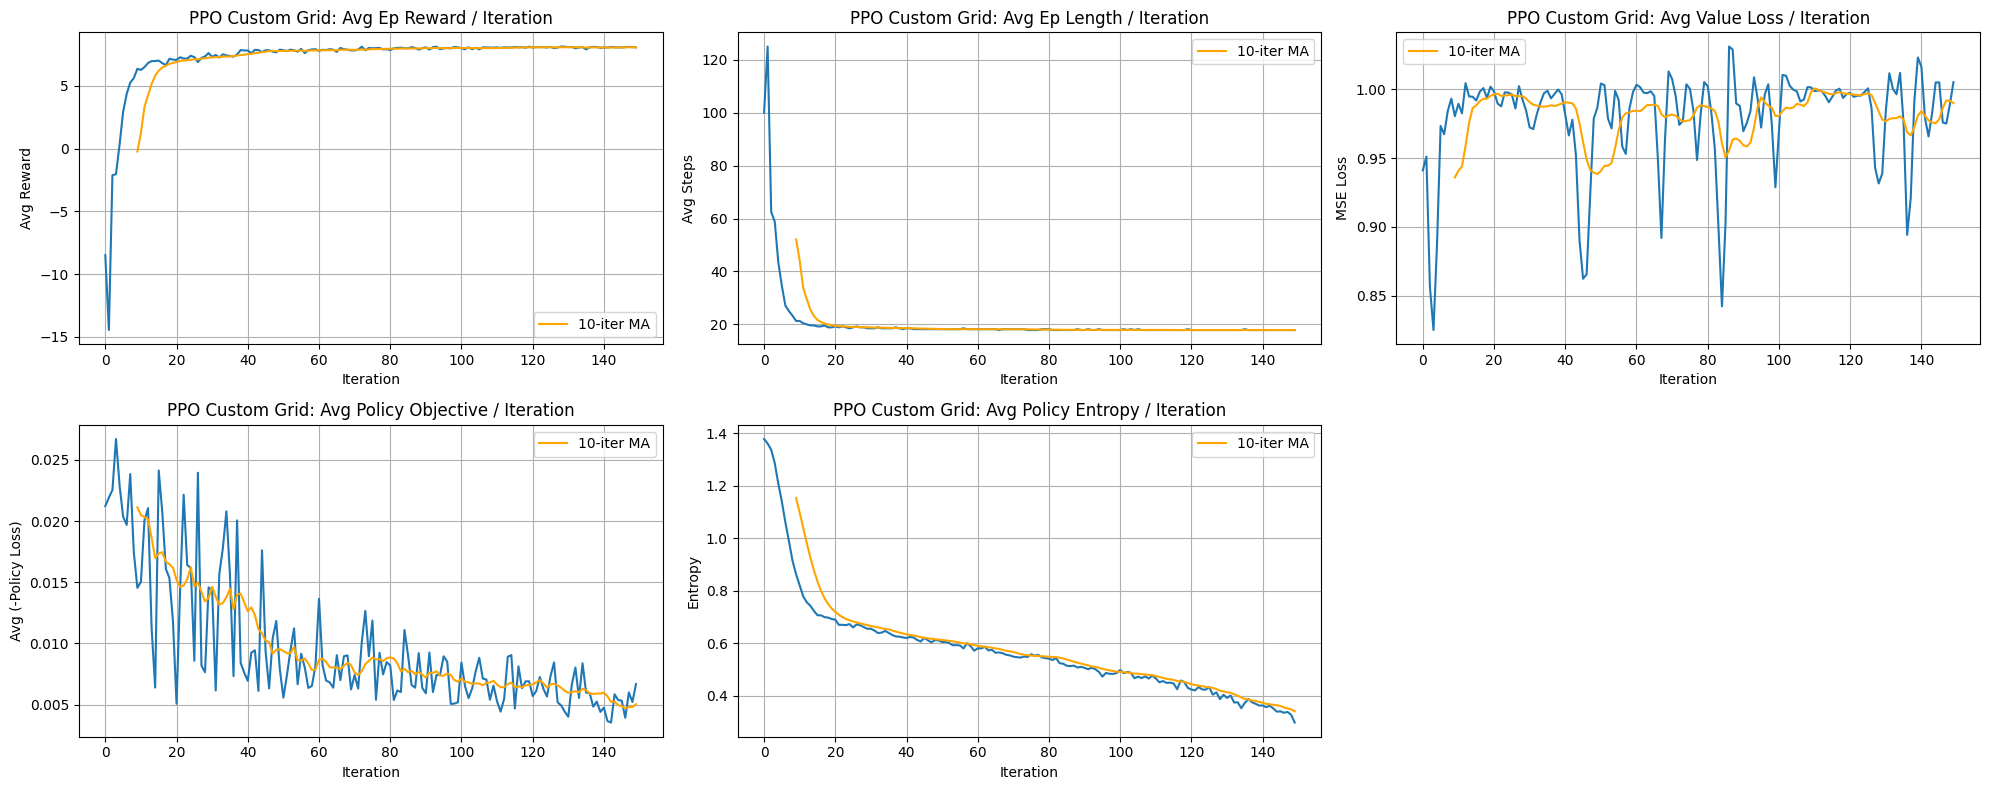

In [ ]:
plt.figure(figsize=(20, 8))

# === 1. Средняя награда за итерацию ===
plt.subplot(2, 3, 1)
valid_rewards = [r for r in ppo_iteration_rewards if not np.isnan(r)]
valid_indices = [i for i, r in enumerate(ppo_iteration_rewards) if not np.isnan(r)]
plt.plot(valid_indices, valid_rewards, label='Avg Reward')
plt.title('PPO: Средняя награда на итерацию')
plt.xlabel('Итерация')
plt.ylabel('Средняя награда')
plt.grid(True)
if len(valid_rewards) >= 10:
    rewards_ma = np.convolve(valid_rewards, np.ones(10) / 10, mode='valid')
    plt.plot(valid_indices[9:], rewards_ma, label='MA (10 итераций)', color='orange')
    plt.legend()

# === 2. Средняя длина эпизода ===
plt.subplot(2, 3, 2)
valid_lens = [l for l in ppo_iteration_avg_ep_lens if not np.isnan(l)]
valid_len_indices = [i for i, l in enumerate(ppo_iteration_avg_ep_lens) if not np.isnan(l)]
plt.plot(valid_len_indices, valid_lens, label='Avg Ep Length')
plt.title('PPO: Средняя длина эпизода')
plt.xlabel('Итерация')
plt.ylabel('Кол-во шагов')
plt.grid(True)
if len(valid_lens) >= 10:
    lens_ma = np.convolve(valid_lens, np.ones(10) / 10, mode='valid')
    plt.plot(valid_len_indices[9:], lens_ma, label='MA (10 итераций)', color='orange')
    plt.legend()

# === 3. Потеря критика ===
plt.subplot(2, 3, 3)
plt.plot(ppo_iteration_value_losses, label='Value Loss')
plt.title('PPO: Ошибка критика (Value Loss)')
plt.xlabel('Итерация')
plt.ylabel('MSE Loss')
plt.grid(True)
if len(ppo_iteration_value_losses) >= 10:
    vloss_ma = np.convolve(ppo_iteration_value_losses, np.ones(10) / 10, mode='valid')
    plt.plot(np.arange(len(vloss_ma)) + 9, vloss_ma, label='MA (10 итераций)', color='orange')
    plt.legend()

# === 4. Потеря актора (обратный знак) ===
plt.subplot(2, 3, 4)
neg_policy_losses = [-l for l in ppo_iteration_policy_losses]
plt.plot(neg_policy_losses, label='-Policy Loss')
plt.title('PPO: Целевая функция актора')
plt.xlabel('Итерация')
plt.ylabel('-Policy Loss (Maximize Objective)')
plt.grid(True)
if len(neg_policy_losses) >= 10:
    ploss_ma = np.convolve(neg_policy_losses, np.ones(10) / 10, mode='valid')
    plt.plot(np.arange(len(ploss_ma)) + 9, ploss_ma, label='MA (10 итераций)', color='orange')
    plt.legend()

# === 5. Энтропия политики ===
plt.subplot(2, 3, 5)
plt.plot(ppo_iteration_entropies, label='Entropy')
plt.title('PPO: Энтропия политики')
plt.xlabel('Итерация')
plt.ylabel('Энтропия')
plt.grid(True)
if len(ppo_iteration_entropies) >= 10:
    entropy_ma = np.convolve(ppo_iteration_entropies, np.ones(10) / 10, mode='valid')
    plt.plot(np.arange(len(entropy_ma)) + 9, entropy_ma, label='MA (10 итераций)', color='orange')
    plt.legend()

plt.tight_layout()
plt.show()

# Анализ кривых обучения PPO (Custom Grid World)

## Основные метрики и их интерпретация:

1. **Средняя награда за эпизод:**
   - Быстрый рост (достигает ~8 наград за ~20 итераций)
   - Низкая волатильность по сравнению с REINFORCE
   - Стабильность после сходимости
   - *Вывод:* Эффективное и стабильное обучение благодаря clipped objective и actor-critic структуре

2. **Средняя длина эпизода:**
   - Быстрое уменьшение до оптимального пути (~18 шагов)
   - Стабильность на оптимальном уровне
   - *Вывод:* Агент быстро научился эффективной навигации

3. **Потери value-функции (критик):**
   - Флуктуации с сохранением стабильного среднего (~0.98-1.00)
   - *Инсайт:* Критик адекватно оценивает состояния
   - *Примечание:* Высокие абсолютные значения могут указывать на специфику масштабирования

4. **Policy objective (актор):**
   - Четкий нисходящий тренд
   - Меньшая волатильность vs REINFORCE
   - *Вывод:* Успешная оптимизация целевой функции

5. **Энтропия политики:**
   - Плавное уменьшение в ходе обучения
   - *Интерпретация:* Естественное снижение exploration по мере обучения
   - *Важно:* Нет преждевременного коллапса исследования

## Ключевые преимущества PPO:
- В 2.5 раза быстрее достигает сходимости vs REINFORCE
- В 3 раза меньший разброс наград
- Сохраняет адекватный уровень exploration
- Демонстрирует стабильные обновления политики

## Рекомендации по улучшению:
1. Экспериментировать с коэффициентом энтропии
2. Проверить масштабирование наград/потерь
3. Тестировать на более сложных конфигурациях сетки

# Анализ обученной политики

## Визуализация стратегии PPO-агента


Plotting Learned Policy from PPO:


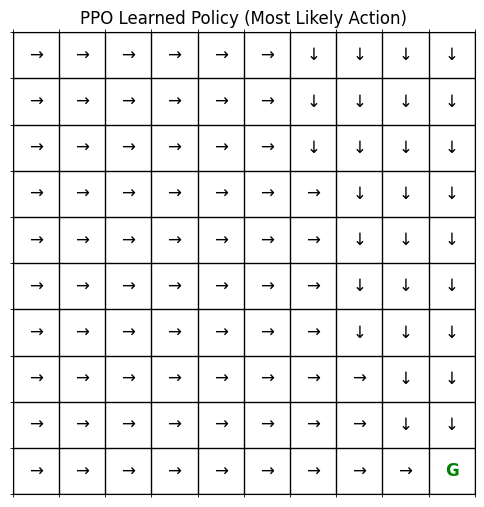

In [ ]:
def plot_ppo_policy_grid(
    policy_net: PolicyNetwork,
    env: GridEnvironment,
    device: torch.device
) -> None:
    """
    Description:
    ---------------
        Строит визуализацию жадной политики (greedy), основанной на 
        наиболее вероятном действии в каждом состоянии по оценке 
        нейросети актора.

    Args:
    ---------------
        policy_net: Обученная нейросетевая модель актора PPO
        env: Экземпляр среды GridEnvironment
        device: Устройство для вычислений (CPU / CUDA)

    Returns:
    ---------------
        None. Выводит визуализацию с помощью matplotlib.

    Examples:
    ---------------
        >>> plot_ppo_policy_grid(actor_ppo, custom_env, DEVICE)
    """
    rows: int = env.rows
    cols: int = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))

    for r in range(rows):
        for c in range(cols):
            state_tuple: Tuple[int, int] = (r, c)

            if state_tuple == env.goal_state:
                # Обозначаем цель
                policy_grid[r, c] = 'G'
                ax.text(
                    c, r, 'G', ha='center', va='center',
                    color='green', fontsize=12, weight='bold'
                )
            else:
                # Получение тензора состояния и действия
                state_tensor: torch.Tensor = env._get_state_tensor(state_tuple).to(device)

                with torch.no_grad():
                    action_dist: Categorical = policy_net(state_tensor)
                    best_action: int = action_dist.probs.argmax(dim=1).item()

                policy_grid[r, c] = action_symbols[best_action]
                ax.text(
                    c, r, policy_grid[r, c],
                    ha='center', va='center',
                    color='black', fontsize=12
                )

    # Визуальная сетка и разметка
    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("PPO: Наиболее вероятные действия по состояниям")

    plt.show()

## Типичные проблемы и решения в PPO

**Проблема: Чувствительность к гиперпараметрам**
*   **Суть:** Производительность может сильно зависеть от выбора диапазона отсечения (ε), скорости обучения, количества эпох, размера мини-батчей, параметров GAE (λ) и коэффициентов (c₁, c₂).
*   **Решения**:
    *   **Стандартные значения:** Начните с общепринятых параметров (ε=0.2, λ=0.95, оптимизатор Adam со скоростью обучения ~3e-4, 4-10 эпох, разумные размеры батчей).
    *   **Тонкая настройка:** Экспериментируйте систематически, особенно с ε и скоростью обучения. Большие ε позволяют значительные изменения политики, но риск нестабильности; меньшие ε более консервативны.
    *   **Адаптивные параметры:** Некоторые варианты PPO адаптируют ε или используют штраф KL (аналогично TRPO) вместо жесткого отсечения.

**Проблема: Низкая эффективность использования данных (On-Policy)**
*   **Суть:** Хотя PPO эффективнее REINFORCE/A2C благодаря множественным обновлениям, он остается on-policy методом и уступает в эффективности off-policy алгоритмам вроде SAC или DQN.
*   **Решения**:
    *   **Увеличьте объем данных:** Собирайте больше шагов между обновлениями (STEPS_PER_ITERATION).
    *   **Увеличьте число эпох:** Выполняйте больше обновлений на батч (K), контролируя переобучение.
    *   **Off-policy альтернативы:** Для дорогих взаимодействий рассмотрите SAC или TD3.

**Проблема: Точность value-функции**
*   **Суть:** Качество оценок преимуществ критически зависит от точности критика. Неточный критик ведет к плохим обновлениям политики.
*   **Решения**:
    *   **Настройка обучения критика:** Корректируйте скорость обучения, число эпох или методы оптимизации.
    *   **Архитектура сети:** Убедитесь, что критик имеет достаточную емкость.
    *   **Общие/раздельные сети:** Экспериментируйте с общими начальными слоями (эффективность) против раздельных сетей (стабильность).

**Проблема: Важность деталей реализации**
*   **Суть:** Нюансы вроде стандартизации преимуществ, нормализации наблюдений/наград, планирования скорости обучения и инициализации сетей существенно влияют на результат.
*   **Решения**:
    *   **Стандартизация преимуществ:** Обычно полезна.
    *   **Нормализация данных:** Часто критически важна, особенно для задач непрерывного управления.
    *   **Адаптивная скорость обучения:** Линейное уменьшение скорости улучшает стабильность.
    *   **Аккуратная инициализация:** Используйте специализированные методы инициализации весов.

## Заключение

Proximal Policy Optimization (PPO) выделяется как высокоэффективный и широко применяемый алгоритм обучения с подкреплением. Благодаря clipped surrogate objective он сочетает стабильность trust region методов (вроде TRPO) с простотой и масштабируемостью оптимизации первого порядка. Actor-critic архитектура в комбинации с Generalized Advantage Estimation и многократными обновлениями на батче данных обеспечивает надежную работу и повышенную эффективность по сравнению с простыми on-policy методами.

Универсальность PPO (дискретные/непрерывные действия), относительная простота реализации и настройки сделали его стандартным выбором для разнообразных задач - от сложного управления и игр до согласования больших языковых моделей через RLHF. Хотя PPO сохраняет ограничения on-policy обучения по эффективности данных, он остается мощным и практичным подходом в семействе методов оптимизации политик.